## Curriculum Logs Anomaly Detection
By: Scott Schmidl, Rajaram Gautam
01/31/2022

### Goal


### Description


### Initial Questions
<p>1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?</p>
<p>2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?</p>
<p>3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?</p>
<p>4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?</p>
<p>5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?</p>
<p>6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?</p>
<p>7. Which lessons are least accessed?</p>

### Data Dictionary
<table>
<thead><tr>
<th>Variable</th>
<th>Meaning</th>
</tr>
</thead>
<tbody>
<tr>
<td>path</td>
<td>The lesson that was accessed</td>
</tr>
<tr>
<td>user_id</td>
<td>id of the user</td>
</tr>
<tr>
<td>cohort_id</td>
<td>id of the cohort</td>
</tr>
<tr>
<td>ip</td>
<td>ip address of the user</td>
</tr>
<tr>
<td>name</td>
<td>name of cohort</td>
</tr>
<tr>
<td>slack</td>
<td>slack channel name</td>
</tr>
<tr>
<td>start_date</td>
<td>start date of cohort</td>
</tr>
<tr>
<td>end_date</td>
<td>end date of cohort</td>
</tr>
<tr>
<td>created_at</td>
<td>date time cohort information was entered into database</td>
</tr>
<tr>
<td>updated_at</td>
<td>date time cohort information was updated</td>
</tr>
<tr>
<td>deleted_at</td>
<td>date time cohort information was deleted</td>
</tr>
<tr>
<td>program_id</td>
<td>id of the program</td>
</tr>
<tr>
<td>program_name</td>
<td>name of program, either web dev or data science</td>
</tr>
</tbody>
</table>

### Wrangling and Prepare
- To wrangle the curriculum logs, we used the curriculum logs database in our MySQL server and saved it to a CSV.
- To prepare the data we performed some feature engineering to create date time columns and program_name

In [8]:
# imports
from wrangle import Wrangle
import pandas as pd

# get and prep Scott's data
logs = Wrangle().prep_data()

# get and prep Rajaram's work
cur_df = Wrangle().get_work()

### Exploratory Data Analysis

### Question 1
- Which lesson appears to attract the most traffic consistently across cohorts (per program)?

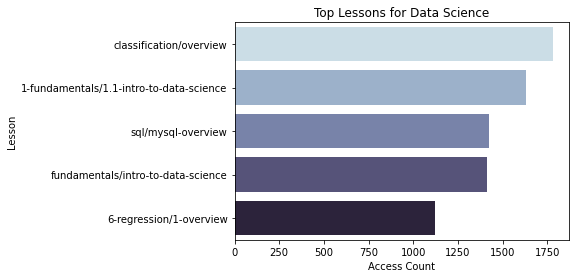

,path
classification/overview,1785
1-fundamentals/1.1-intro-to-data-science,1633
sql/mysql-overview,1424
fundamentals/intro-to-data-science,1413
6-regression/1-overview,1124


In [9]:
# import viz
import seaborn as sns
import matplotlib.pyplot as plt

# Removing all the paths that are not a lesson
lesson = cur_df.copy()
lesson = lesson[lesson.path.str.endswith('jpg') == False]
lesson = lesson[lesson.path.str.endswith('jpeg') == False]
lesson = lesson[lesson.path.str.endswith('svg') == False]
lesson = lesson[(lesson.path != '/') & (lesson.path != 'search/search_index.json') 
                & (lesson.path != 'toc') & (lesson.path != 'appendix')]
lesson = lesson.set_index("date_time")

# Top lessons for Data Science
top_course_lessons = pd.DataFrame(lesson[lesson.course_subdomain == 'ds'].path.value_counts().head(5))
plt.figure(figsize=(6, 4))
sns.barplot(data=top_course_lessons,
x="path", y=top_course_lessons.index, palette="ch:s=.25,rot=-.25", )
plt.title('Top Lessons for Data Science')
plt.xlabel('Access Count')
plt.ylabel('Lesson')
plt.show()
top_course_lessons

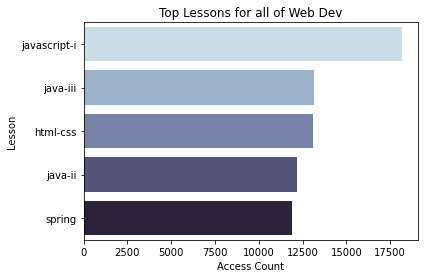

,path
javascript-i,18193
java-iii,13162
html-css,13111
java-ii,12173
spring,11877


In [10]:
# Top lessons for all Web Dev
top_course_lessons = pd.DataFrame(lesson[lesson.course_subdomain != 'ds'].path.value_counts().head(5))
plt.figure(figsize=(6, 4))
sns.barplot(data=top_course_lessons,
x="path", y=top_course_lessons.index, palette="ch:s=.25,rot=-.25", )
plt.title('Top Lessons for all of Web Dev')
plt.xlabel('Access Count')
plt.ylabel('Lesson')
plt.show()
top_course_lessons

### Take Away
- Data Science top courses: classification/overview, fundamentals/1.1-intro-to-data-science, sql/mysql-overview, fundamentals/intro-to-data-science, and 6-regression/1-overview
- Web Dev top courses: javascript-i, java-iii, html-css, java-ii, spring

### Question 2
- Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

In [2]:
# get name and path count of cohorts that accessed curriculum the most
logs[["name", "path"]][logs["name"] != "Staff"].groupby(by=["name"], sort=False).count().nlargest(n=10, columns="path", keep="first")

,path
name,
Ceres,40730
Zion,38096
Jupiter,37109
Fortuna,36902
Voyageurs,35636
Ganymede,33844
Apex,33568
Deimos,32888
Darden,32015


### Take Away
- These are the top 10 cohorts who accessed the curriculum the most.

### Question 3
- Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

In [3]:
# create variables for if person was a current student or staff
was_student = (logs.index < logs["end_date"]) & (logs.index > logs["start_date"])
not_staff = (logs["name"] != "Staff")

# students that hardly access the curriculum
logs[["user_id", "path"]][was_student & not_staff].groupby(by=["user_id"], sort=False).count().nsmallest(n=10, columns="path", keep="first")

,path
user_id,
619,1
879,1
918,1
940,1
832,3
278,4
539,5
956,6
812,7


### Take Away
- These students were active students and not staff. These are the 10 students whom accessed the curriculum the fewest.

### Question 4
- Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?


In [11]:
# organizing accessions by ip address
group_based_ip = lesson.groupby('ip').count()['path'].sort_values(ascending = False)

# defining multiplier
k = 3

# ip addressses whose activity is 3 standard deviations above the mean
anomalos_ip = group_based_ip[group_based_ip > (group_based_ip.mean() + k * group_based_ip.std())]
anomalos_ip

ip
97.105.19.58    241019
97.105.19.61     56968
Name: path, dtype: int64

In [12]:
# Let us look at all the records visited by that first ip
lesson[lesson.ip == '97.105.19.58'].head()

,path,user_id,cohort_id,ip,name,slack,start_date,end_date,created_at,updated_at,program_id,id,course_name,course_subdomain,date_time,date_year,date_month,date_weekday,hour
82285,javascript-ii/promises,211,1,97.105.19.58,Arches,#arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1,1,PHP Full Stack Web Dev,php,2018-07-16 07:51:57,2018,July,Monday,7
82286,javascript-ii/map-filter-reduce,211,1,97.105.19.58,Arches,#arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1,1,PHP Full Stack Web Dev,php,2018-07-16 07:58:03,2018,July,Monday,7
82287,javascript-ii/promises,211,1,97.105.19.58,Arches,#arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1,1,PHP Full Stack Web Dev,php,2018-07-16 07:59:50,2018,July,Monday,7
82288,index.html,53,14,97.105.19.58,Lassen,#lassen,2016-07-18,2016-11-10,2016-07-18 19:06:27,2016-07-18 19:06:27,1,1,PHP Full Stack Web Dev,php,2018-07-16 08:07:37,2018,July,Monday,8
82289,javascript-ii,53,14,97.105.19.58,Lassen,#lassen,2016-07-18,2016-11-10,2016-07-18 19:06:27,2016-07-18 19:06:27,1,1,PHP Full Stack Web Dev,php,2018-07-16 08:07:41,2018,July,Monday,8


In [13]:
# Let us look at all the records visited by that second ip
lesson[lesson.ip == '97.105.19.61'].head()

,path,user_id,cohort_id,ip,name,slack,start_date,end_date,created_at,updated_at,program_id,id,course_name,course_subdomain,date_time,date_year,date_month,date_weekday,hour
1,java-ii,1,8,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,1,PHP Full Stack Web Dev,php,2018-01-26 09:56:02,2018,January,Friday,9
2,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,1,PHP Full Stack Web Dev,php,2018-01-26 09:56:05,2018,January,Friday,9
3,slides/object_oriented_programming,1,8,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,1,PHP Full Stack Web Dev,php,2018-01-26 09:56:06,2018,January,Friday,9
4,javascript-i/conditionals,2,22,97.105.19.61,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,2,Java Full Stack Web Dev,java,2018-01-26 09:56:24,2018,January,Friday,9
5,javascript-i/loops,2,22,97.105.19.61,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,2,Java Full Stack Web Dev,java,2018-01-26 09:56:41,2018,January,Friday,9


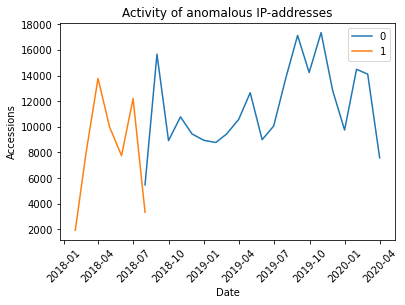

In [23]:
# Plotting the activity of the two anomalous ip addresses
for idx in range(2):
    plt.plot(lesson[lesson.ip == anomalos_ip.index[idx]].resample('M').count().iloc[:,0])
plt.legend(range(2))
plt.xticks(rotation = 90) # Rotates the x labels so that they don't overlap
plt.ylabel('Accessions')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Activity of anomalous IP-addresses')
plt.show()

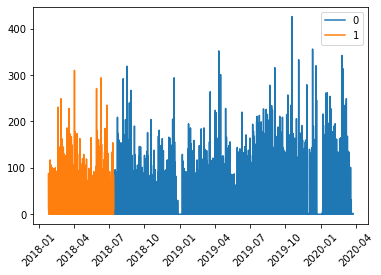

In [24]:
for idx in range(2):
    plt.plot(lesson[lesson.ip == anomalos_ip.index[idx]].resample('H').count().iloc[:,0])
plt.xticks(rotation=45)
plt.legend(range(2))
plt.show()

### Take Away
- There are two anamalous ip addresses, 97.105.19.58 and, 97.105.19.61,  which is active more than 3 standard deviations above the mean.
- For IP Address 97.105.19.61, it looks like the user is glancing over, as he is not staying on the page for a long time.
- Since they are not overlapping in time, it may be same person. Used to access curriculum from one ip and changed the ip address
- The activity has decreased between 2019 and 2020.

### Question 5
- At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?

In [25]:
# To see if ds students are accessing web dev:
lesson[lesson.course_subdomain == 'ds'].path.value_counts().tail()

3-vocabulary                 1
2.1-spreadsheets-overview    1
imports                      1
index.html                   1
bad-charts                   1
Name: path, dtype: int64

In [26]:
# Exploring all ds students from 2020 and later
ds = lesson[lesson.course_subdomain == 'ds']
ds[ds.date_year > 2019].head(1)

,path,user_id,cohort_id,ip,name,slack,start_date,end_date,created_at,updated_at,program_id,id,course_name,course_subdomain,date_year,date_month,date_weekday,hour
date_time,,,,,,,,,,,,,,,,,,
2020-01-01 15:35:02,10-anomaly-detection/1-overview,476,34,136.50.49.145,Bayes,#,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3,3,Data Science,ds,2020,January,Wednesday,15


In [27]:
ds[ds.date_year > 2019].path.value_counts().tail()

grades/getUserDetails/916/3                                  1
appendix/www.opensecrets.org                                 1
b-clustering/project                                         1
10-anomaly-detection/time-series-anomaly-detection-part-1    1
6-regression/8-Project                                       1
Name: path, dtype: int64

In [28]:
# Now exploring web dev:
wd = lesson[lesson.course_subdomain != 'ds']
wd.head(1)

,path,user_id,cohort_id,ip,name,slack,start_date,end_date,created_at,updated_at,program_id,id,course_name,course_subdomain,date_year,date_month,date_weekday,hour
date_time,,,,,,,,,,,,,,,,,,
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,1,PHP Full Stack Web Dev,php,2018,January,Friday,9


In [29]:
# Web dev over all of the years:
wd.path.value_counts().tail()

mysql//ntellij                                                  1
prework/cli/03-filepaths                                        1
appendix/further-reading/css-grid-additional-features           1
appendix/capstone-workbook/sw-planning.md                       1
appendix/professional-development/post-interview-review-form    1
Name: path, dtype: int64

In [30]:
# Web Dev after 2019:
wd[wd.date_year > 2019].path.value_counts().tail()

explore                                                         1
working-with-time-series-data                                   1
modeling-lesson1                                                1
overview                                                        1
appendix/professional-development/post-interview-review-form    1
Name: path, dtype: int64

### Take Away
- Although there are less, there are at least two instances of data science students web dev site: java-ii/object-oriented-programming and spring.
- For web dev, they did seem to access the Data Science curriculum fairly often prior to having access denied. After 2019, there was a large drop off, but there seems to be a few cases where a data science topic was accessed.

### Questions 6
- What topics are grads continuing to reference after graduation and into their jobs (for each program)?


#### Web Dev

In [4]:
# web dev students that continued referencing curriculum after graduation
logs["path"][(logs.index > logs["end_date"]) & (logs["program_name"] == "web dev") & (logs["name"] != "Staff")]

date_time
2018-01-26 09:55:03                                      /
2018-01-26 09:56:02                                java-ii
2018-01-26 09:56:05    java-ii/object-oriented-programming
2018-01-26 09:56:06     slides/object_oriented_programming
2018-01-26 10:14:47                                      /
                                      ...                 
2021-04-21 14:43:09                      jquery/mapbox-api
2021-04-21 14:43:10                jquery/ajax/weather-map
2021-04-21 14:50:36                                 java-i
2021-04-21 14:50:38            java-i/introduction-to-java
2021-04-21 16:30:30                               appendix
Name: path, Length: 104557, dtype: object

#### Data Science

In [5]:
# data science students that continued referencing curriculum after graduation
logs["path"][(logs.index > logs["end_date"]) & (logs["program_name"] == "data science") & (logs["name"] != "Staff")]

date_time
2020-01-30 08:01:31             1-fundamentals/1.1-intro-to-data-science
2020-01-30 08:01:32             1-fundamentals/modern-data-scientist.jpg
2020-01-30 08:01:32                 1-fundamentals/AI-ML-DL-timeline.jpg
2020-01-31 11:05:04                                                    /
2020-01-31 11:05:13             1-fundamentals/1.1-intro-to-data-science
                                             ...                        
2021-04-21 15:20:12                              classification/overview
2021-04-21 15:20:12    classification/classical_programming_vs_machin...
2021-04-21 15:20:12             classification/scale_features_or_not.svg
2021-04-21 15:20:14                               classification/project
2021-04-21 15:20:18                               classification/acquire
Name: path, Length: 11544, dtype: object

### Take Away
- These are the topics by program that got referenced after a student graduated.

### Question 7
7) Which lessons are least accessed?

In [6]:
# top 10 lessons that were accessed the fewest
logs["path"].value_counts(ascending=True).nsmallest(n=10, keep="first")

appendix/professional-development/post-interview-review-form    1
cli-03-file-paths                                               1
cli-07-more-topics                                              1
spring/services                                                 1
8-timeseries/1-overview                                         1
8-timeseries/2-intro-to-timeseries                              1
8-timeseries/3-acquire                                          1
8-timeseries/4-prep                                             1
8-timeseries/6.1-parametric-modeling                            1
8-timeseries/6.2-prophet                                        1
Name: path, dtype: int64

### Take Away
- These are the top 10 least accessed topics, but this can be adjusted based on needs.